### Libraries

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import AdamW
import matplotlib.pyplot as plt
import datetime
import utils
import rnn_utils


### Config

In [18]:
time_stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
from_scratch=False # True: start fresh, False: resume from checkpoint

# Model paths
SAVE_Full_MODEL_PATH = f"./models/rnn_2_heads/full_checkpoint_{time_stamp}.keras" # saving full model checkpoint if from scratch=True
LOAD_MODEL_PATH = "./models/rnn_2_heads/rnn.keras"  # path to load model checkpoint from if from_scratch=False

# TensorBoard directory
log_dir = f"./fit/{time_stamp}/"

#define data destination
TRAIN_NPZ = "./paired_text_motion.npz"
TEST_NPZ  = "./paired_text_motion_val.npz"
NORM_STATS = "motion_norm_stats.npz"   # if exists, used; otherwise computed from train npz

MOTION_LEN = 200         # fixed length for MLP outputs (frames)
NUM_JOINTS = 22
COORDS = 3
OUTPUT_DIM = MOTION_LEN * NUM_JOINTS * COORDS
root_trajectory = False  # whether to reconstruct motion root trajectory from root velocities

# Data loading options
MAX_TRAIN_SAMPLES =0    # 0 = use all; otherwise use first N pairs
MAX_TEST_SAMPLES = 0   # 0 = use all; otherwise use first N pairs

USE_NORMALIZATION = True  #normalize data to zero mean and unity variance

# Training Monitoring and Callbacks
USE_GPU = False
USE_LR_SCHEDULER = False
USE_EARLY_STOPPING = True
USE_LR_LOGGER = False # learning rate logger callback

# Training hyperparams
D_TIME = 32   # Dimension of learnable time embeddings (e.g. 16/32/64)

BATCH_SIZE = 1024
EPOCHS = 50
LEARNING_RATE = 1e-4
HIDDEN_DIMS = [256,256]  # list: number of neurons per hidden Dense layer

# Loss options
USE_VELOCITY_LOSS = True
LAMBDA_VEL = 1
LAMBDA_ROOT = 1.0  # weight for root-velocity loss vs pose loss (tune if needed)

WEIGHT_DECAY = 1e-4

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Utilities Functions

### Load data 

In [3]:
print("Loading train npz:", TRAIN_NPZ)
z_train, motions_train, ids_train = utils.load_npz_pairs(TRAIN_NPZ, max_samples=MAX_TRAIN_SAMPLES)
print("Filtering training motions...")
z_train, motions_train, ids_train = utils.filter_valid_motions(z_train, motions_train, ids_train)
print("Final train samples:", len(z_train))

print("Loading test npz:", TEST_NPZ)
z_test, motions_test, ids_test = utils.load_npz_pairs(TEST_NPZ, max_samples=MAX_TEST_SAMPLES)

print("Filtering test motions...")
z_test, motions_test, ids_test = utils.filter_valid_motions(z_test, motions_test, ids_test)
print("Final test samples:", len(z_test))


print("Train captions:", z_train.shape)
print("Train motions count:", len(motions_train))
print("Train ids_count:", len(ids_train))
print("Test captions:", z_test.shape)
print("Test motions count:", len(motions_test))
print("Test ids_count:", len(ids_test))

Loading train npz: ./paired_text_motion.npz
Filtering training motions...
[Filter] Skipping sample at index=2384, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=2385, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=2386, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=14019, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=14020, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=14021, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=37332, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=37333, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=37334, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=48967, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=48968, shape=(22, 3) (not 3D)
[Filter] Skipping sample at index=48969, shape=(22, 3) (not 3D)
Final train samples: 69884
Loading test npz: ./paired_text_motion_val.npz
Filtering test motions...
Final test samples: 4362
Train captions: (69884, 384)
Train m

### Compute data statistics

In [4]:
if os.path.exists(NORM_STATS):
    stats = np.load(NORM_STATS)
    pose_mean     = stats["pose_mean"]
    pose_std      = stats["pose_std"]
    rootvel_mean  = stats["rootvel_mean"]
    rootvel_std   = stats["rootvel_std"]
    print("Loaded normalization stats from", NORM_STATS)
else:
    print("Computing normalization stats (root-relative pose + root velocity)...")
    pose_mean, pose_std, rootvel_mean, rootvel_std = rnn_utils.compute_pose_rootvel_stats(
        motions_train,
        target_len=MOTION_LEN
    )

print("pose_mean:", pose_mean, "pose_std:", pose_std)
print("rootvel_mean:", rootvel_mean, "rootvel_std:", rootvel_std)


Computing normalization stats (root-relative pose + root velocity)...
pose_mean: [[[[-0.00023493 -0.02042538  0.01167196]]]] pose_std: [[[[0.1076361  0.23476106 0.1065274 ]]]]
rootvel_mean: [[[ 3.9163851e-06 -8.9967598e-06  2.7644455e-03]]] rootvel_std: [[[0.01206515 0.0096471  0.01815101]]]


### Prepare dataset

In [5]:

print("Preparing training tensors...")
X_train, Y_pose_train, Y_root_train = rnn_utils.prepare_xy_multi(
    z_train, motions_train,
    pose_mean, pose_std,
    rootvel_mean, rootvel_std,
    motion_len=MOTION_LEN,
    use_normalization=USE_NORMALIZATION
)

print("Preparing test tensors...")
X_test, Y_pose_test, Y_root_test = rnn_utils.prepare_xy_multi(
    z_test, motions_test,
    pose_mean, pose_std,
    rootvel_mean, rootvel_std,
    motion_len=MOTION_LEN,
    use_normalization=USE_NORMALIZATION
)


print("Shapes:")
print("  X_train:", X_train.shape)
print("  Y_pose_train:", Y_pose_train.shape)
print("  Y_root_train:", Y_root_train.shape)
print("  X_test:", X_test.shape)
print("  Y_pose_test:", Y_pose_test.shape)
print("  Y_root_test:", Y_root_test.shape)


Preparing training tensors...
Preparing test tensors...
Shapes:
  X_train: (69884, 384)
  Y_pose_train: (69884, 200, 22, 3)
  Y_root_train: (69884, 200, 3)
  X_test: (4362, 384)
  Y_pose_test: (4362, 200, 22, 3)
  Y_root_test: (4362, 200, 3)


### Model

In [8]:
tf.keras.backend.clear_session()  # Clear any existing session

# Optional mixed precision on GPU
# if USE_GPU:
#     mixed_precision.set_global_policy('mixed_float16')
#     print("Mixed precision policy:", mixed_precision.global_policy())

# ---------------------------
# Inputs: sentence embedding z_text (384-d)
# ---------------------------
inputs = tf.keras.Input(
    shape=(X_train.shape[1],),  # 384 for all-MiniLM
    dtype=tf.float32,
    name="z_text"
)

CAP_DIM = X_train.shape[1]      # typically 384

# 1) Repeat text embedding across time -> [B, T, CAP_DIM]
z_seq = tf.keras.layers.RepeatVector(MOTION_LEN, name="repeat_text")(inputs)

time_indices = tf.keras.layers.Lambda(
    rnn_utils.make_time_indices(MOTION_LEN),
    name="time_indices"
)(inputs)  # [B, T]

time_embedding_layer = tf.keras.layers.Embedding(
    input_dim=MOTION_LEN,   # one embedding per frame index
    output_dim=D_TIME,
    name="time_embedding"
)

time_seq = time_embedding_layer(time_indices)  # [B, T, D_TIME]

# 3) Concatenate text + time -> [B, T, CAP_DIM + D_TIME]
decoder_input = tf.keras.layers.Concatenate(
    axis=-1,
    name="concat_text_time"
)([z_seq, time_seq])

# 4) Stacked GRU decoder over time using HIDDEN_DIMS

# Learn initial hidden state from caption only
init_state = tf.keras.layers.Dense(
    HIDDEN_DIMS[0],           # same size as first GRU layer
    activation="tanh",
    name="init_state_from_caption"
)(inputs)                     # inputs is z_text: (B, CAP_DIM)

# First GRU layer uses learned initial_state
x = tf.keras.layers.GRU(
    HIDDEN_DIMS[0],
    return_sequences=True,
    name="gru_layer_1"
)(decoder_input, initial_state=init_state)

# Additional GRU layers (if any) stack on top, default zero init is fine
for i, h in enumerate(HIDDEN_DIMS[1:], start=2):
    x = tf.keras.layers.GRU(
        h,
        return_sequences=True,
        name=f"gru_layer_{i}"
    )(x)


# 5) Two heads:
#    - pose_out:    (B, T, 22, 3)   root-relative pose
#    - rootvel_out: (B, T, 3)       root velocities

# Pose head
pose_out_flat = tf.keras.layers.Dense(
    NUM_JOINTS * COORDS,
    name="pose_frame_dense"
)(x)                   # (B, T, 66)

pose_out = tf.keras.layers.Reshape(
    (MOTION_LEN, NUM_JOINTS, COORDS),
    name="pose_out"
)(pose_out_flat)       # (B, T, 22, 3)

# Root-velocity head
rootvel_out = tf.keras.layers.Dense(
    COORDS,
    name="rootvel_out"
)(x)                   # (B, T, 3)

model = tf.keras.Model(
    inputs=inputs,
    outputs=[pose_out, rootvel_out],
    name="GRU_TimeCond_Motion_Decoder"
)

model.summary()

optimizer = AdamW(
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

model.compile(
    optimizer=optimizer,
    loss=[rnn_utils.pose_loss_with_vel(USE_VELOCITY_LOSS, LAMBDA_VEL), "mse"],      # [pose_out, rootvel_out]
    loss_weights=[1.0, LAMBDA_ROOT]
)



Model: "GRU_TimeCond_Motion_Decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ z_text (InputLayer) │ (None, 384)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_indices        │ (None, 200)       │          0 │ z_text[0][0]      │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_text         │ (None, 200, 384)  │          0 │ z_text[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_embedding      │ (None, 200, 32)   │      6,400 │ time_indices[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_text_time    │ (None, 200, 416)  │          0 │ repeat_text[0][0… │
│ (Concatenate)       │                   │            │ time_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ init_state_from_ca… │ (None, 256)       │     98,560 │ z_text[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_layer_1 (GRU)   │ (None, 200, 256)  │    517,632 │ concat_text_time… │
│                     │                   │            │ init_state_from_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_layer_2 (GRU)   │ (None, 200, 256)  │    394,752 │ gru_layer_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pose_frame_dense    │ (None, 200, 66)   │     16,962 │ gru_layer_2[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pose_out (Reshape)  │ (None, 200, 22,   │          0 │ pose_frame_dense… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rootvel_out (Dense) │ (None, 200, 3)    │        771 │ gru_layer_2[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,035,077 (3.95 MB)

 Trainable params: 1,035,077 (3.95 MB)

 Non-trainable params: 0 (0.00 B)

### Training callbacks and monitors 

In [9]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,   # enables gradients & weights monitoring
    write_graph=False
)

# Reduce LR on Plateau
reduceLR_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Early stopping
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

# Save best weights only
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=SAVE_Full_MODEL_PATH,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)
class LRTensorBoard(tf.keras.callbacks.Callback):
    def __init__(self, log_dir):
        super().__init__()
        self.file_writer = tf.summary.create_file_writer(log_dir)

    def on_epoch_end(self, epoch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        with self.file_writer.as_default():
            tf.summary.scalar("learning_rate", lr, step=epoch)

lr_logger = LRTensorBoard(log_dir=log_dir)





callbacks_list = [tensorboard_cb, checkpoint_cb]

if USE_LR_SCHEDULER:
    callbacks_list.append(reduceLR_cb)

if USE_EARLY_STOPPING:
    callbacks_list.append(earlystop_cb)

# Optional: add LR logger if you use it
if USE_LR_LOGGER:
    callbacks_list.append(lr_logger)

### Training

In [19]:
if not from_scratch:
    if os.path.exists(LOAD_MODEL_PATH):
        print(f"Loading model from: {LOAD_MODEL_PATH}")
        
        model = tf.keras.models.load_model(LOAD_MODEL_PATH,
            custom_objects={'pose_loss_with_vel': rnn_utils.pose_loss_with_vel(USE_VELOCITY_LOSS, LAMBDA_VEL),
                            'make_time_indices': rnn_utils.make_time_indices(MOTION_LEN)},
            safe_mode=False
        )
    else:
         raise FileNotFoundError(f"Model file not found:\n{LOAD_MODEL_PATH}")
else:
    print("Training from scratch")

tf.config.run_functions_eagerly(False)  # for performance

history = model.fit(
    X_train,
    [Y_pose_train, Y_root_train],
    validation_data=(X_test, [Y_pose_test, Y_root_test]),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    callbacks=callbacks_list,
    verbose=1
)

# ----------------------------
# 1) Combined Loss plot
# ----------------------------
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='train_total_loss')
plt.plot(history.history['val_loss'], label='val_total_loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Total Training / Validation Loss (Pose + RootVel)')
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------
# 2) Pose-only loss plot
# ----------------------------
plt.figure(figsize=(8,5))
plt.plot(history.history['pose_out_loss'], label='train_pose_loss')
plt.plot(history.history['val_pose_out_loss'], label='val_pose_loss')
plt.xlabel('Epoch')
plt.ylabel('Pose Loss')
plt.title('Pose Head Loss (Position + Optional Pose Velocity)')
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------
# 3) Root-velocity-only loss plot
# ----------------------------
plt.figure(figsize=(8,5))
plt.plot(history.history['rootvel_out_loss'], label='train_rootvel_loss')
plt.plot(history.history['val_rootvel_out_loss'], label='val_rootvel_loss')
plt.xlabel('Epoch')
plt.ylabel('Root Velocity Loss (MSE)')
plt.title('Root Velocity Head Loss')
plt.legend()
plt.grid(True)
plt.show()


Loading model from: ./models/rnn_2_heads/rnn.keras
Epoch 1/50
 2/69 ━━━━━━━━━━━━━━━━━━━━ 2:53 3s/step - loss: 1.7025 - pose_out_loss: 0.7522 - rootvel_out_loss: 0.9503

KeyboardInterrupt: 

### Choosing Model for Inferance

In [21]:
if from_scratch:
    print("Using model already in memory (just trained).")
else:
    print(f"\nLoading model from file:\n{LOAD_MODEL_PATH}\n")

    if not os.path.exists(LOAD_MODEL_PATH):
        raise FileNotFoundError(f"Model file not found:\n{LOAD_MODEL_PATH}")

    model = tf.keras.models.load_model(LOAD_MODEL_PATH,
            custom_objects={'pose_loss_with_vel': rnn_utils.pose_loss_with_vel(USE_VELOCITY_LOSS, LAMBDA_VEL),
                            'make_time_indices': rnn_utils.make_time_indices(MOTION_LEN)},
            safe_mode=False
        )

    print("Model loaded successfully for inference.")


Loading model from file:
./models/rnn_2_heads/rnn.keras

Model loaded successfully for inference.


### Run Inference Example

In [22]:
sample_idx = 0   # pick any index from test set

motion_id = ids_test[sample_idx]
print("Test motion ID:", motion_id)

# Input embedding
z = X_test[sample_idx:sample_idx+1]   # (1, CAP_DIM)

# Forward pass through model -> two heads
pred_pose_out, pred_rootvel_out = model.predict(z)   # (1,T,J,3), (1,T,3)

# Remove batch dimension
pred_pose_out = pred_pose_out[0]       # (T,J,3)
pred_rootvel_out = pred_rootvel_out[0] # (T,3)

if USE_NORMALIZATION:
    # denormalize root-relative pose
    pred_pose_rel = (
        pred_pose_out * pose_std[0, 0, 0, :] + pose_mean[0, 0, 0, :]
    )  # (T,J,3)

    # denormalize root velocities
    pred_root_vel = (
        pred_rootvel_out * rootvel_std[0, 0, :] + rootvel_mean[0, 0, :]
    )  # (T,3)

else:
    # model already trained on raw values
    pred_pose_rel = pred_pose_out       # (T,J,3) root-relative, unnormalized
    pred_root_vel = pred_rootvel_out    # (T,3)   root velocity, unnormalized

if root_trajectory:
    # calculate root trajectory from root velocities
    root_pred = np.zeros_like(pred_root_vel, dtype=np.float32)  # (T,3)
    for t in range(1, MOTION_LEN):
        root_pred[t] = root_pred[t - 1] + pred_root_vel[t]
    root_pred_expanded = root_pred[:, None, :]                   # (T,1,3)
    pred_world = pred_pose_rel + root_pred_expanded              # (T,22,3)
    print("Predicted motion (world coords) shape:", pred_world.shape)

else:
    #consider pose only
    pred_world = pred_pose_rel
    print("Predicted motion (pose only) shape:", pred_world.shape)

# GT motion (padded) for comparison
if root_trajectory:
    gt_motion_fixed = rnn_utils.pad_or_truncate_motion(motions_test[sample_idx], MOTION_LEN)
    print("GT motion (world coords) shape:", gt_motion_fixed.shape)
else:
    gt_motion_fixed, _ = rnn_utils.extract_pose_and_rootvel(motions_test[sample_idx], target_len=MOTION_LEN)
    print("GT motion (pose only) shape:", gt_motion_fixed.shape)

Test motion ID: 012698
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Predicted motion (pose only) shape: (200, 22, 3)
GT motion (pose only) shape: (200, 22, 3)


### Animation of Generated Motion

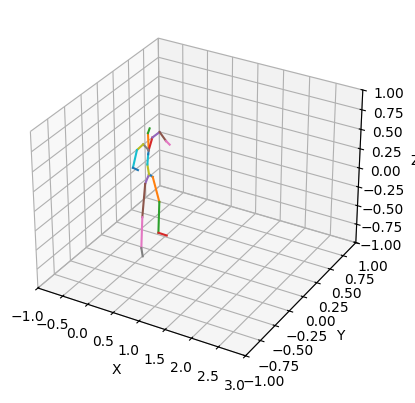

In [23]:
# SMPL 22-joint skeleton edges
edges = [
    (0, 1), (1, 4), (4, 7), (7, 10),
    (0, 2), (2, 5), (5, 8), (8, 11),
    (0, 3), (3, 6), (6, 9), (9, 12), (12, 15),
    (9, 13), (13, 16), (16, 18), (18, 20),
    (9, 14), (14, 17), (17, 19), (19, 21),
]

def save_motion_animation(motion, label, motion_id, base_dir):
    """
    motion: (T, 22, 3)
    label:  'generated' or 'gt'
    """
    pose = copy.deepcopy(motion)  # (T,22,3)

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # FIXED AXIS LIMITS 
    ax.set(xlim3d=(-1, 3), xlabel='X')
    ax.set(ylim3d=(-1, 1), ylabel='Y')
    ax.set(zlim3d=(-1, 1), zlabel='Z')


    # Auto axis limits from motion
    #coords = pose.reshape(-1, 3)
    #x_min, x_max = coords[:, 0].min(), coords[:, 0].max()
    #y_min, y_max = coords[:, 1].min(), coords[:, 1].max()
    #z_min, z_max = coords[:, 2].min(), coords[:, 2].max()
    #margin = 0.1

    #ax.set_xlim(x_min - margin, x_max + margin)
    #ax.set_ylim(y_min - margin, y_max + margin)
    #ax.set_zlim(z_min - margin, z_max + margin)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Create one line per edge
    lines = [ax.plot([], [], [])[0] for _ in edges]

    def update_lines(frame_num, pose, lines):
        frame = pose[frame_num]
        for n, (i, j) in enumerate(edges):
            x = [frame[i, 0], frame[j, 0]]
            y = [frame[i, 1], frame[j, 1]]
            z = [frame[i, 2], frame[j, 2]]
            # Keep your preferred orientation:
            lines[n].set_data_3d([z, x, y])
        return lines

    ani = FuncAnimation(
        fig,
        update_lines,
        frames=pose.shape[0],
        fargs=(pose, lines),
        interval=100
    )

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    save_path = f"{base_dir}/{label}_{motion_id}_{timestamp}.mp4"
    ani.save(save_path, writer='ffmpeg', fps=30)
    print(f"Saved {label} animation to:", save_path)
    plt.close(fig)


# save directory
anim_dir = "/Users/akhidre/pubgit/CS230_T2Motion/animations"

utils.animate_pose(pred_world, motion_id)
# Save predicted motion
# save_motion_animation(pred_world, "generated_RNN_2heads", motion_id, anim_dir)

# Save GT motion
# save_motion_animation(gt_motion_fixed, "gt_fixed", motion_id, anim_dir)

### Static Frames of Generated Motions

In [43]:
motion_id

'012698'

In [15]:
# Request which frames to export
requested_frames = [1, 10, 100]   # modify as needed

max_frame = min(pred_world.shape[0], gt_motion_fixed.shape[0]) - 1
safe_frames = [f for f in requested_frames if 0 <= f <= max_frame]

print("Requested frames:", requested_frames)
print("Using frames:", safe_frames)

# Output directory
static_dir = f"/Users/akhidre/pubgit/CS230_T2Motion/frames"
os.makedirs(static_dir, exist_ok=True)
print("Saving side-by-side frames to:", static_dir)


# Utility: plot one skeleton using SAME orientation as animation
def plot_skeleton(ax, frame_pose):
    """
    ax: matplotlib 3D axis
    frame_pose: (22,3)
    """

    # Fixed axis limits (same as your animation)
    ax.set(xlim3d=(-1, 3), xlabel='X')
    ax.set(ylim3d=(-1, 1), ylabel='Y')
    ax.set(zlim3d=(-1, 1), zlabel='Z')

    # Draw skeleton edges
    for (i, j) in edges:
        x = [frame_pose[i, 0], frame_pose[j, 0]]
        y = [frame_pose[i, 1], frame_pose[j, 1]]
        z = [frame_pose[i, 2], frame_pose[j, 2]]

        # SAME orientation as animation (z, x, y)
        ax.plot([z[0], z[1]], [x[0], x[1]], [y[0], y[1]], 'b-', linewidth=2)


# Save one side-by-side figure
def save_sbs_frame(frame_idx, gt_pose, pred_pose, save_dir):
    fig = plt.figure(figsize=(10, 4))

    # Left: GT
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.set_title(f"GT — Frame {frame_idx}")
    plot_skeleton(ax1, gt_pose)

    # Right: Predicted
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.set_title(f"PRED — Frame {frame_idx}")
    plot_skeleton(ax2, pred_pose)

    # Save high-resolution PNG
    out_path = os.path.join(save_dir, f"sbs_frame_{frame_idx}_{time_stamp}.png")
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.close(fig)

    print("Saved:", out_path)



# Generate all requested frames
for f in safe_frames:
    save_sbs_frame(
        f,
        gt_motion_fixed[f],   # GT frame
        pred_world[f],        # Predicted frame
        static_dir
    )

print("Finished side-by-side static frame generation.")


Requested frames: [1, 10, 100]
Using frames: [1, 10, 100]
Saving side-by-side frames to: /Users/akhidre/pubgit/CS230_T2Motion/frames
Saved: /Users/akhidre/pubgit/CS230_T2Motion/frames/sbs_frame_1_20251203-101146.png
Saved: /Users/akhidre/pubgit/CS230_T2Motion/frames/sbs_frame_10_20251203-101146.png
Saved: /Users/akhidre/pubgit/CS230_T2Motion/frames/sbs_frame_100_20251203-101146.png
Finished side-by-side static frame generation.


### Troubleshoot/Debug

In [ ]:
# Analyze predicted vs ground-truth motion for sample_idx 
# 1) Rebuild the ground-truth motion for the same sample_idx
gt_motion_raw = motions_test[sample_idx]  # this is an object array (T, 22, 3)
gt_motion_fixed = rnn_utils.pad_or_truncate_motion(gt_motion_raw, target_len=MOTION_LEN)

if USE_NORMALIZATION:
    # If you ever turn normalization back on, you need to denormalize both
    gt_motion_real = denormalize_motion(gt_motion_fixed, mean, std)
    pred_motion_real = denormalize_motion(pred_3d, mean, std)
else:
    gt_motion_real = gt_motion_fixed.astype(np.float32)
    pred_motion_real = pred_real.astype(np.float32)  # already float32

print("GT motion shape:", gt_motion_real.shape)
print("Pred motion shape:", pred_motion_real.shape)


# 2) Simple per-frame stats to see "scale" and position
def motion_frame_stats(name, motion, frame_idx):
    f = motion[frame_idx]                 # [22, 3]
    min_xyz = f.min(axis=0)
    max_xyz = f.max(axis=0)
    center = f.mean(axis=0)
    # approximate skeleton scale = max distance from the frame center
    scale = np.linalg.norm(f - center, axis=1).max()
    print(f"{name} frame {frame_idx:3d} | "
          f"center {center} | min {min_xyz} | max {max_xyz} | scale {scale:.3f}")

for fi in [0, 1, 5, 10, 50, 100, 199]:
    print("==== frame", fi, "====")
    motion_frame_stats("GT  ", gt_motion_real, fi)
    motion_frame_stats("Pred", pred_motion_real, fi)
    print()
    

# 3) Track how skeleton scale changes over time
def skeleton_scale_over_time(motion):
    # assume joint 0 is root
    root = motion[:, 0, :]                             # [T, 3]
    dists = np.linalg.norm(motion - root[:, None, :], axis=2)  # [T, 22]
    return dists.max(axis=1)                           # [T]

gt_scale = skeleton_scale_over_time(gt_motion_real)
pred_scale = skeleton_scale_over_time(pred_motion_real)

print("First 10 GT scales:   ", gt_scale[:10])
print("First 10 Pred scales: ", pred_scale[:10])
print("Mean GT scale:", gt_scale.mean(), "Mean Pred scale:", pred_scale.mean())




GT motion shape: (200, 22, 3)
Pred motion shape: (200, 22, 3)
==== frame 0 ====
GT   frame   0 | center [-0.02864403  0.96302295  0.02325513] | min [-0.44450423  0.02759657 -0.21121013] | max [0.21953316 1.5654216  0.27112737] | scale 0.958
Pred frame   0 | center [0.00153125 0.19702187 0.01724212] | min [-0.05245192  0.00887568  0.00560129] | max [0.0564133 0.3203984 0.031524 ] | scale 0.192

==== frame 1 ====
GT   frame   1 | center [-0.03720071  0.95801127  0.03821034] | min [-0.45528355  0.02489816 -0.20703632] | max [0.20616621 1.5639188  0.26679406] | scale 0.953
Pred frame   1 | center [0.00263812 0.43550768 0.03544001] | min [-0.1042376   0.02060861  0.01222342] | max [0.11616597 0.7143726  0.06515045] | scale 0.421

==== frame 5 ====
GT   frame   5 | center [-0.05281306  0.92984957  0.11754942] | min [-0.3982659   0.02329702 -0.04673944] | max [0.1719622 1.5448701 0.2994337] | scale 0.916
Pred frame   5 | center [0.00562967 0.87676024 0.07665091] | min [-0.20799063  0.03914583